#ARIMA-XGBoost

In [1]:
#import libraries
import pandas as pd
import numpy as np
import yfinance as yf
from google.colab import drive
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
import statsmodels.api as sm
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap
from joblib import Parallel, delayed, dump, load
from sklearn.preprocessing import StandardScaler, MinMaxScaler

Download data from google drive

In [65]:
drive.mount('/content/gdrive')

#import time series
sp500_data = pd.read_csv('/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/sp500_data.csv', index_col=0)
sp500_data = sp500_data.iloc[2:] #remove the first 2 rows that don't contain the time series
sp500_data.index.name = 'Date'
sp500_data.index = pd.to_datetime(sp500_data.index)
# sp500_data['Adj Close'] = sp500_data['Adj Close'].astype(float)
# sp500_data['Close'] = sp500_data['Close'].astype(float)
# sp500_data['High'] = sp500_data['High'].astype(float)
# sp500_data['Low'] = sp500_data['Low'].astype(float)
# sp500_data['Open'] = sp500_data['Open'].astype(float)
# sp500_data['Volume'] = sp500_data['Volume'].astype(float)


#save Close price and Log Returns into a pd.Series
Close_price = sp500_data['Close'].copy().astype(float)
Log_return = sp500_data['Log Return'].copy().astype(float)


#drop columns not needed
sp500_data.drop(['Open', 'High', 'Low', 'Close', 'Log Return', 'Adj Close'], axis=1, inplace=True)


#import ARIMA residuals
residuals = pd.read_csv('/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/close_price_residuals.csv', index_col=0)
sp500_data.insert(0, 'Residuals', residuals.values)



#import ARIMA fitted values (predictions on the training set)
fitted_values = pd.read_csv('/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/fitted_values.csv', index_col=0)


#import ARIMA predictions on the test set
ARIMA_predictions = pd.read_csv('/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/arima_predictions.csv', index_col=0).squeeze() #to read as a pd.Series
ARIMA_predictions.index = pd.to_datetime(ARIMA_predictions.index)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##Feature Engineering

In [67]:
#time features
sp500_data['Year'] = sp500_data.index.year #this will be treated as a numerical feature

#those will be treated as categorical features
sp500_data['Month'] = sp500_data.index.month
sp500_data['Day'] = sp500_data.index.day
sp500_data['Day_of_week'] = sp500_data.index.dayofweek
sp500_data['Quarter'] = sp500_data.index.quarter
# sp500_data['Index_hash'] = sp500_data.index.map(lambda x: hash(x))


#lag features
for lag in (1,5,10,25,365):
  sp500_data[f'lag_{lag}'] = sp500_data['Residuals'].shift(lag)


#rolling features
for window in (5,10,25):
  sp500_data[f'rolling_mean_Residuals_{window}'] = sp500_data['Residuals'].shift(1).rolling(window=window).mean() #shift by one because the current close price won't be available at the day of the prediction
  sp500_data[f'rolling_std_Residuals_{window}'] = sp500_data['Residuals'].shift(1).rolling(window=window).std()
  sp500_data[f'rolling_skew_Residuals_{window}'] = sp500_data['Residuals'].shift(1).rolling(window=window).skew()
  sp500_data[f'rolling_mean_volume_{window}'] = sp500_data['Volume'].shift(1).rolling(window=window).mean()
  sp500_data[f'rolling_std_volume_{window}'] = sp500_data['Volume'].shift(1).rolling(window=window).std()
  sp500_data[f'rolling_skew_volume_{window}'] = sp500_data['Volume'].shift(1).rolling(window=window).skew()


#substitute NaN values with 0
sp500_data.fillna(0, inplace=True)


#visualize
sp500_data.columns

Index(['Residuals', 'Volume', 'Year', 'Month', 'Day', 'Day_of_week', 'Quarter',
       'lag_1', 'lag_5', 'lag_10', 'lag_25', 'lag_365',
       'rolling_mean_Residuals_5', 'rolling_std_Residuals_5',
       'rolling_skew_Residuals_5', 'rolling_mean_volume_5',
       'rolling_std_volume_5', 'rolling_skew_volume_5',
       'rolling_mean_Residuals_10', 'rolling_std_Residuals_10',
       'rolling_skew_Residuals_10', 'rolling_mean_volume_10',
       'rolling_std_volume_10', 'rolling_skew_volume_10',
       'rolling_mean_Residuals_25', 'rolling_std_Residuals_25',
       'rolling_skew_Residuals_25', 'rolling_mean_volume_25',
       'rolling_std_volume_25', 'rolling_skew_volume_25'],
      dtype='object')

Encode categorical features

In [68]:
#cyclical encoding to reflect the periodic nature of the categorical features (https://stackoverflow.com/questions/58936445/whats-the-proper-way-to-present-numerical-categorical-data-specifically-hour-o)
sp500_data['month_sin'] = np.sin(2 * np.pi * sp500_data['Month'] / 12)
sp500_data['month_cos'] = np.cos(2 * np.pi * sp500_data['Month'] / 12)

sp500_data['day_sin'] = np.sin(2 * np.pi * sp500_data['Day'] / 31)
sp500_data['day_cos'] = np.cos(2 * np.pi * sp500_data['Day'] / 31)

sp500_data['day_of_week_sin'] = np.sin(2 * np.pi * sp500_data['Day_of_week'] / 5)
sp500_data['day_of_week_cos'] = np.cos(2 * np.pi * sp500_data['Day_of_week'] / 5)

sp500_data['quarter_sin'] = np.sin(2 * np.pi * sp500_data['Quarter'] / 4)
sp500_data['quarter_cos'] = np.cos(2 * np.pi * sp500_data['Quarter'] / 4)


#numerical / categorical columns
num_cols = [
       'lag_1', 'lag_5', 'lag_10', 'lag_25', 'lag_365',
       'rolling_mean_Residuals_5', 'rolling_std_Residuals_5',
       'rolling_skew_Residuals_5', 'rolling_mean_volume_5',
       'rolling_std_volume_5', 'rolling_skew_volume_5',
       'rolling_mean_Residuals_10', 'rolling_std_Residuals_10',
       'rolling_skew_Residuals_10', 'rolling_mean_volume_10',
       'rolling_std_volume_10', 'rolling_skew_volume_10',
       'rolling_mean_Residuals_25', 'rolling_std_Residuals_25',
       'rolling_skew_Residuals_25', 'rolling_mean_volume_25',
       'rolling_std_volume_25', 'rolling_skew_volume_25']
cat_cols = ['month_sin', 'month_cos', 'day_sin', 'day_cos', 'day_of_week_sin', 'day_of_week_cos', 'quarter_sin', 'quarter_cos']


#drop columns not needed
sp500_data.drop(['Month', 'Day', 'Day_of_week', 'Volume', 'Quarter'], axis=1, inplace=True)


#visualise
sp500_data

,Residuals,Year,lag_1,lag_5,lag_10,lag_25,lag_365,rolling_mean_Residuals_5,rolling_std_Residuals_5,rolling_skew_Residuals_5,...,rolling_std_volume_25,rolling_skew_volume_25,month_sin,month_cos,day_sin,day_cos,day_of_week_sin,day_of_week_cos,quarter_sin,quarter_cos
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,-0.306564,2000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,5.000000e-01,0.866025,5.712682e-01,0.820763,0.000000,1.000000,1.000000e+00,6.123234e-17
2000-01-04,-56.446985,2000,-0.306564,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,5.000000e-01,0.866025,7.247928e-01,0.688967,0.951057,0.309017,1.000000e+00,6.123234e-17
2000-01-05,-60.496419,2000,-56.446985,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,5.000000e-01,0.866025,8.486443e-01,0.528964,0.587785,-0.809017,1.000000e+00,6.123234e-17
2000-01-06,-59.933922,2000,-60.496419,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,5.000000e-01,0.866025,9.377521e-01,0.347305,-0.587785,-0.809017,1.000000e+00,6.123234e-17
2000-01-07,-21.433871,2000,-59.933922,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,5.000000e-01,0.866025,9.884683e-01,0.151428,-0.951057,0.309017,1.000000e+00,6.123234e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31,288.792765,2024,315.280792,387.120069,493.011489,405.877631,-644.077896,396.591694,56.341513,-0.548087,...,1.195016e+09,1.474773,-2.449294e-16,1.000000,-2.449294e-16,1.000000,0.951057,0.309017,-2.449294e-16,1.000000e+00
2025-01-02,274.534470,2025,288.792765,451.913308,468.365536,422.735876,-643.699194,376.926234,74.657066,-0.133943,...,1.210424e+09,1.505368,5.000000e-01,0.866025,3.943559e-01,0.918958,-0.587785,-0.809017,1.000000e+00,6.123234e-17
2025-01-03,347.276415,2025,274.534470,448.285888,288.739844,455.823366,-626.490156,341.450466,72.220274,0.901211,...,1.167135e+09,1.789773,5.000000e-01,0.866025,5.712682e-01,0.820763,-0.951057,0.309017,1.000000e+00,6.123234e-17


###train val test split

In [69]:
#train / vall / test split
train_data = sp500_data.loc[: '2018']
val_data = sp500_data.loc['2019': '2021']
train_val_data = sp500_data.loc[: '2021']
test_data = sp500_data.loc['2022':]

Scale datasets

In [70]:
# Initialize scalers
train_scaler = StandardScaler()
train_val_scaler = StandardScaler()

# Fit scaler only to the train set (when predicting on the val set) and on the train + validation set (when predicting on the test set)
train_scaler.fit(train_data[num_cols])
train_val_scaler.fit(train_val_data[num_cols])

# Create a copy of the datasets
train_data_scaled = train_data.copy()
val_data_scaled = val_data.copy()
train_val_data_scaled = train_val_data.copy()
test_data_scaled = test_data.copy()

# Scale numerical features
train_data_scaled.loc[:, num_cols] = train_scaler.transform(train_data[num_cols])
val_data_scaled.loc[:, num_cols] = train_scaler.transform(val_data[num_cols])

# Scale numerical features for train+val set and test set
train_val_data_scaled.loc[:, num_cols] = train_val_scaler.transform(train_val_data[num_cols])
test_data_scaled.loc[:, num_cols] = train_val_scaler.transform(test_data[num_cols])


#scale the target
# target_scaler_train = StandardScaler()
# target_scaler_train_val = StandardScaler()

# #fit scalers
# target_scaler_train.fit(train_data['Residuals'].values.reshape(-1, 1))
# target_scaler_train_val.fit(train_val_data['Residuals'].values.reshape(-1, 1))

# #scale target feature
# train_data_scaled['Residuals'] = target_scaler_train.transform(train_data['Residuals'].values.reshape(-1, 1))
# val_data_scaled['Residuals'] = target_scaler_train.transform(val_data['Residuals'].values.reshape(-1, 1))

# train_val_data_scaled['Residuals'] = target_scaler_train_val.transform(train_val_data['Residuals'].values.reshape(-1, 1))
# test_data_scaled['Residuals'] = target_scaler_train_val.transform(test_data['Residuals'].values.reshape(-1, 1))

In [71]:
#X, y split
X_train = train_data_scaled.drop(columns=['Residuals'])
y_train = train_data_scaled['Residuals']
X_val = val_data_scaled.drop(columns=['Residuals'])
y_val = val_data_scaled['Residuals']
X_train_val = train_val_data_scaled.drop(columns=['Residuals'])
y_train_val = train_val_data_scaled['Residuals']
X_test = test_data_scaled.drop(columns=['Residuals'])
y_test = test_data_scaled['Residuals']


#convert to Dmatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtrain_val = xgb.DMatrix(X_train_val, label=y_train_val)
dtest = xgb.DMatrix(X_test, label=y_test)


##Find the best hyperparameter using Bayesian Optimization

In [ ]:
!pip install arm-mango

In [ ]:
from mango import scheduler #to perform Bayesian optimization
from mango.tuner import Tuner
import time
from joblib import Parallel, delayed, dump, load
from scipy.stats import uniform


In [ ]:
#parallel bayesian optimization
class OptimizationMangoParallel:
  def __init__(self, njobs: int, configuration_params: dict, dtrain, dval):
      self.conf_dict = configuration_params
      self.njobs = njobs
      # self.dtrain = xgb.DMatrix(X_train, label=y_train)
      # self.dval = xgb.DMatrix(X_val, label=y_val)
      self.dtrain = dtrain
      self.dval = dval
      self.space = {
          "learning_rate": uniform(0.01, 0.5),
          "max_depth": range(5, 15),
          "subsample": uniform(0.7, 0.3),
          "objective": ['reg:squarederror'],
          "colsample_bytree": uniform(0.3, 0.7),
          "gamma": uniform(0, 0.01),
          "num_boost_round": range(500, 2000),
          "early_stopping_rounds": range(10, 30),
          # "early_stopping_rounds" : [20]
      }


    #other hyperparameters that can be used

    # "min_child_weight": randint(1, 10),                     # Min child weight between 1 and 10
    # "scale_pos_weight": uniform(0.5, 2),                    # Scaling for positive class weight
    # "objective": ['reg:squarederror'],                      # Objective function
    # "booster": ['gbtree', 'gblinear', 'dart'],              # Choice of tree booster types
    # "max_delta_step": uniform(0, 10),                       # Maximum step size to help with convergence
    # "lambda": uniform(0, 1),                                # L2 regularization term
    # "alpha": uniform(0, 1),                                 # L1 regularization term




  #This is the loss function that mango optimizes
  def XGBoost_objetive_function(self, **params):
    try:
        # model = xgb.train(params, self.dtrain, num_boost_round=params['num_boost_round'])  # Train model
        model = xgb.train(params, self.dtrain, evals = [(self.dval, 'validation')], num_boost_round = best_params['num_boost_round'], early_stopping_rounds= best_params['early_stopping_rounds'], verbose_eval=False)
        y_pred = model.predict(self.dval)  # Predict
        rmse = np.sqrt(mean_squared_error(dval.get_label(), y_pred)) # Compute RMSE
        # print(rmse)
        return rmse
    except Exception as e:
        print(f"Error with params {params}: {e}")
        return 1e5  # Penalize error cases


  def _objective2(self, params_batch):
    global parameters
    # print(f"Parameters batch: {params_batch}")
    results_batch = Parallel(self.njobs, backend="threading")(delayed(self.XGBoost_objetive_function)(**params) for params in params_batch)
    # print(f"Results batch: {results_batch}")
    rmse = [result for result in results_batch]
    return rmse


  def mango_optimization(self):
      tuner = Tuner(self.space, self._objective2, self.conf_dict)
      optimisation_results = tuner.minimize()
      return optimisation_results['best_params'], optimisation_results['best_objective']


# Parallel hyperparameters tuning
config_params = {'num_iteration': 40, 'initial_random': 10}
start_time = time.time()
optim = OptimizationMangoParallel(njobs=4, configuration_params=config_params, dtrain = dtrain, dval = dval) #initialize a new instance of the class
best_parameters, best_objective = optim.mango_optimization()
print(f'The optimisation in parallel takes {(time.time() - start_time) / 60.} minutes.')


# Inspect the results
print('best parameters:', best_parameters)
print('best accuracy:', best_objective)


58.08241257377852
64.9551753495247
56.03866768036714
74.85399199232798
59.41449549891529
62.58759291672252
61.10586916241148
66.55598926491326
58.24647923909221
88.25416619946336


  0%|          | 0/40 [00:00<?, ?it/s]

77.25986296765772
84.57493672403781
53.891449508044644
61.30509320704928
53.58677296057419
56.38128559401936
65.09528772787628
57.205310153565506
60.75630312272649
60.614117902205756
54.45481525353727
55.595366052958944
54.18910392666592
56.94359702536801
57.48743493826499
63.74619895224636
59.78785125929117
77.16351158113044
78.48265321374367
60.776737059323324
64.7718087367587
64.98764155351
59.62486692529699
59.67945994605787
72.68567616477988
59.04230805638445
56.09010477361961
53.21741961049972
64.8300738589931
85.71573374660424
59.55919619641034
57.59513190148973
60.707500646671534
88.41994359747834
56.183119962761054
58.199637059918594
58.56254168888591
61.39177827244561
57.87369016808825
58.50225147577121
The optimisation in parallel takes 8.777886660893758 minutes.
best parameters: {'colsample_bytree': 0.808411208122622, 'early_stopping_rounds': 17, 'gamma': 0.0005022072348654649, 'learning_rate': 0.3196968954529591, 'max_depth': 14, 'num_boost_round': 1949, 'objective': 'reg:

##Residual prediction using XGBOOST


Prediction on the validation set

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:19:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "early_stopping_rounds", "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)


RMSE: 57.496516113886194
Mean Squared Error: 3305.849365234375
Mean Absolute Error: 40.91309356689453
R2 Score: 0.9881919026374817


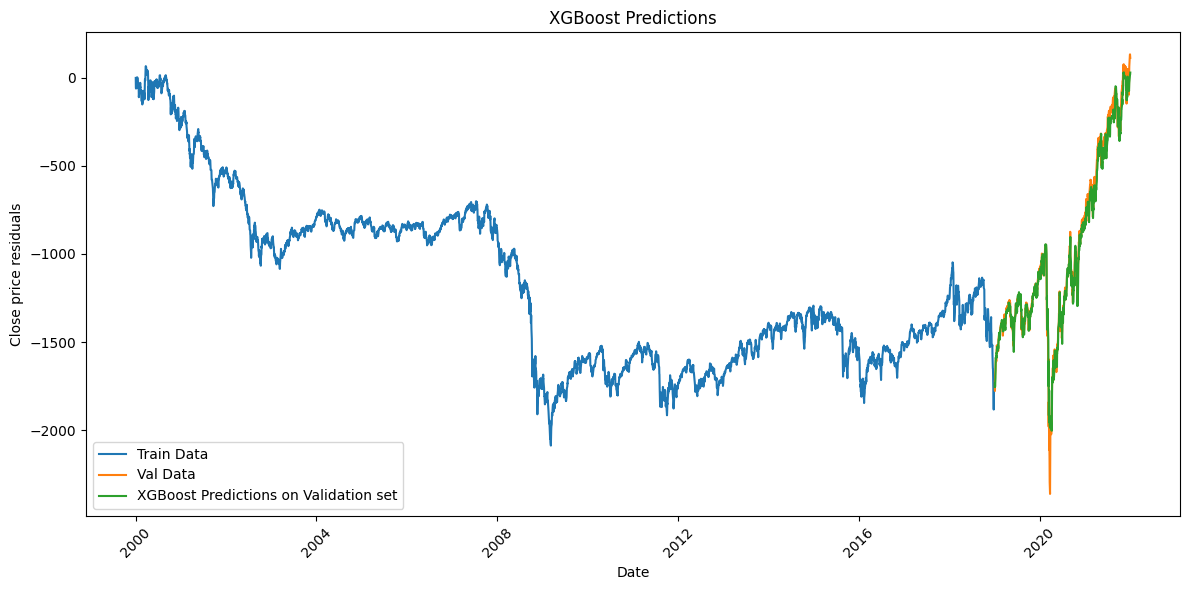

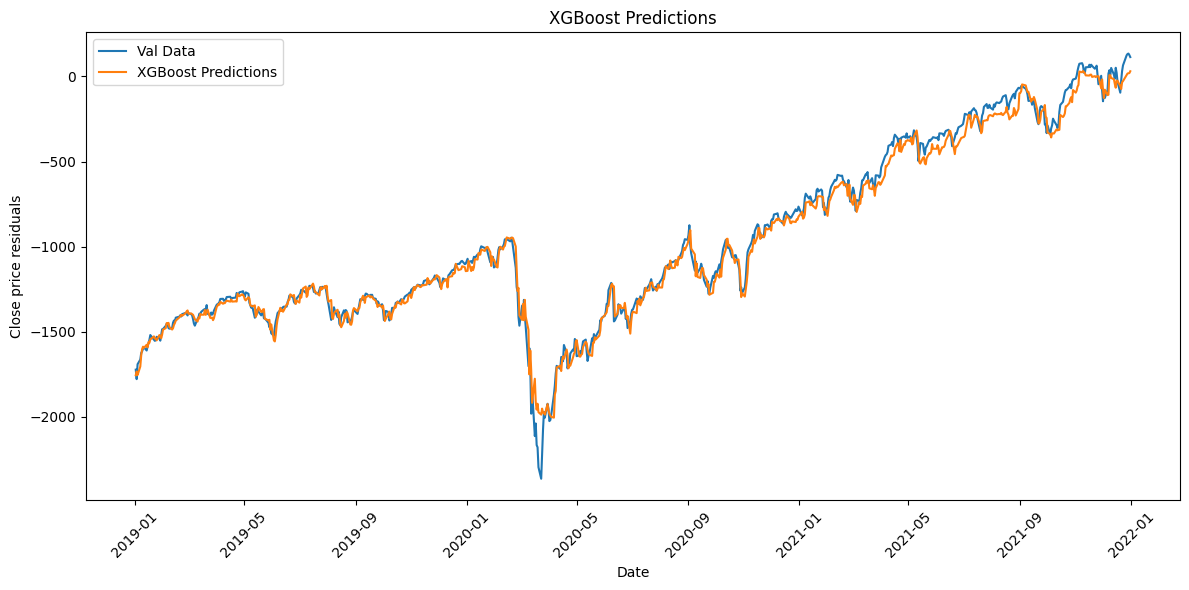

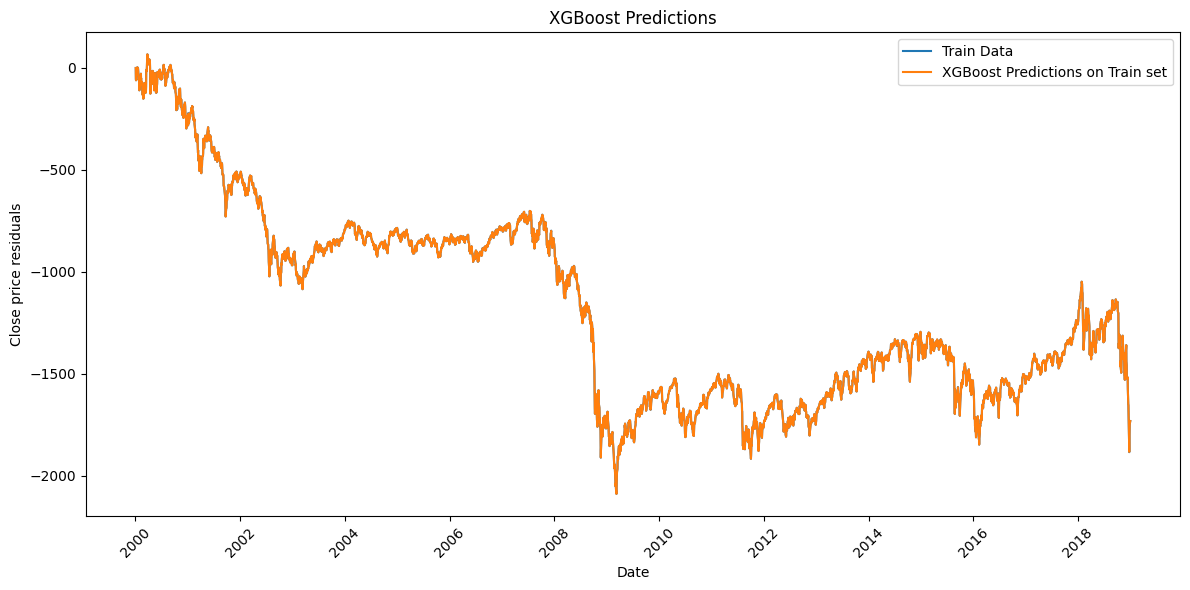

In [72]:
# train model using the best hyperparameters
best_params ={'colsample_bytree': 0.808411208122622, 'early_stopping_rounds': 17, 'gamma': 0.0005022072348654649, 'learning_rate': 0.3196968954529591, 'max_depth': 14, 'num_boost_round': 1949, 'objective': 'reg:squarederror', 'subsample': 0.7712161804793591}
model = xgb.train(best_params, dtrain, evals = [(dval, 'validation')], num_boost_round = best_params['num_boost_round'], early_stopping_rounds= best_params['early_stopping_rounds'], verbose_eval=False)  # Initialize xgboost model


#prediction on the val set
y_pred = model.predict(dval)  # Make predictions


#compute metrics
mse = mean_squared_error(dval.get_label(), y_pred)
rmse = np.sqrt(mean_squared_error(dval.get_label(), y_pred))
mae = mean_absolute_error(dval.get_label(), y_pred)
r2 = r2_score(dval.get_label(), y_pred)
print(f'RMSE: {rmse}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R2 Score: {r2}')


#visualize
plt.figure(figsize=(12, 6))
sns.lineplot(x=train_data.index, y=y_train, label="Train Data")
sns.lineplot(x=val_data.index, y=y_val, label="Val Data")
sns.lineplot(x=val_data.index, y=y_pred, label="XGBoost Predictions on Validation set")
plt.title('XGBoost Predictions')
plt.xlabel('Date')
plt.ylabel('Close price residuals')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()


# #close up
plt.figure(figsize=(12, 6))
# sns.lineplot(x=val_data.index, y=val_data['Residuals'].values, label="Val Data")
sns.lineplot(x= val_data.index, y = dval.get_label(), label="Val Data")
sns.lineplot(x=val_data.index, y=y_pred, label="XGBoost Predictions")
plt.title('XGBoost Predictions')
plt.xlabel('Date')
plt.ylabel('Close price residuals')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()


#fitted values
fitted_values = model.predict(dtrain)
plt.figure(figsize=(12, 6))
sns.lineplot(x=train_data.index, y=y_train, label="Train Data")
sns.lineplot(x=train_data.index, y=fitted_values, label="XGBoost Predictions on Train set")
plt.title('XGBoost Predictions')
plt.xlabel('Date')
plt.ylabel('Close price residuals')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()


Prediction on the Test set

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:23:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "early_stopping_rounds", "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)


RMSE: 111.11316637639078
Mean Squared Error: 12346.1357421875
Mean Absolute Error: 69.05628967285156
R2 Score: 0.9472101330757141


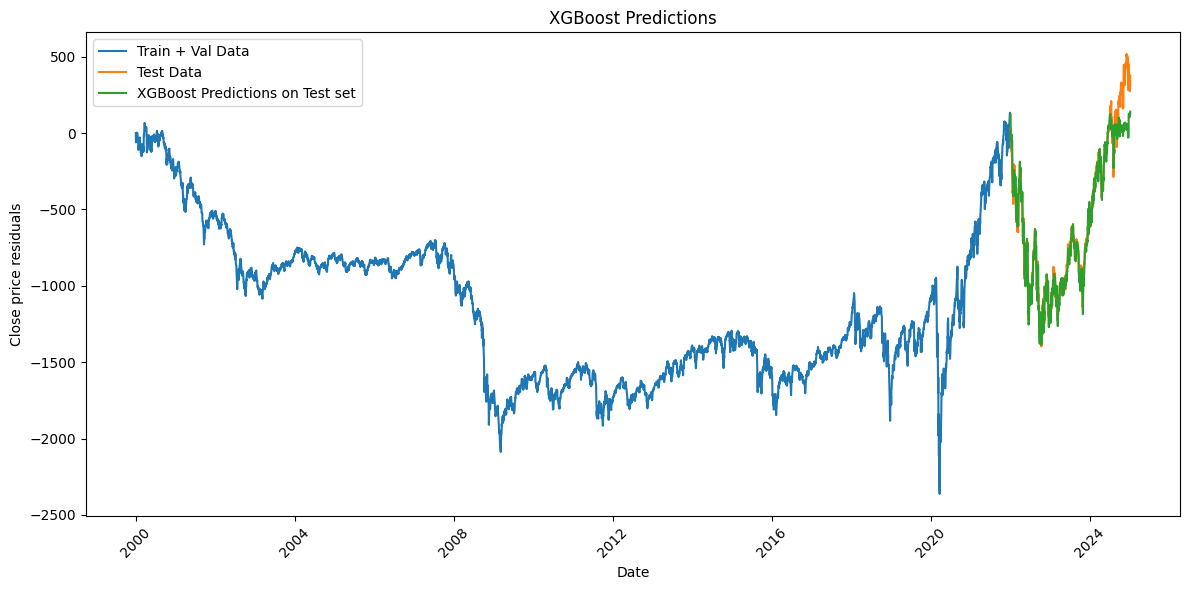

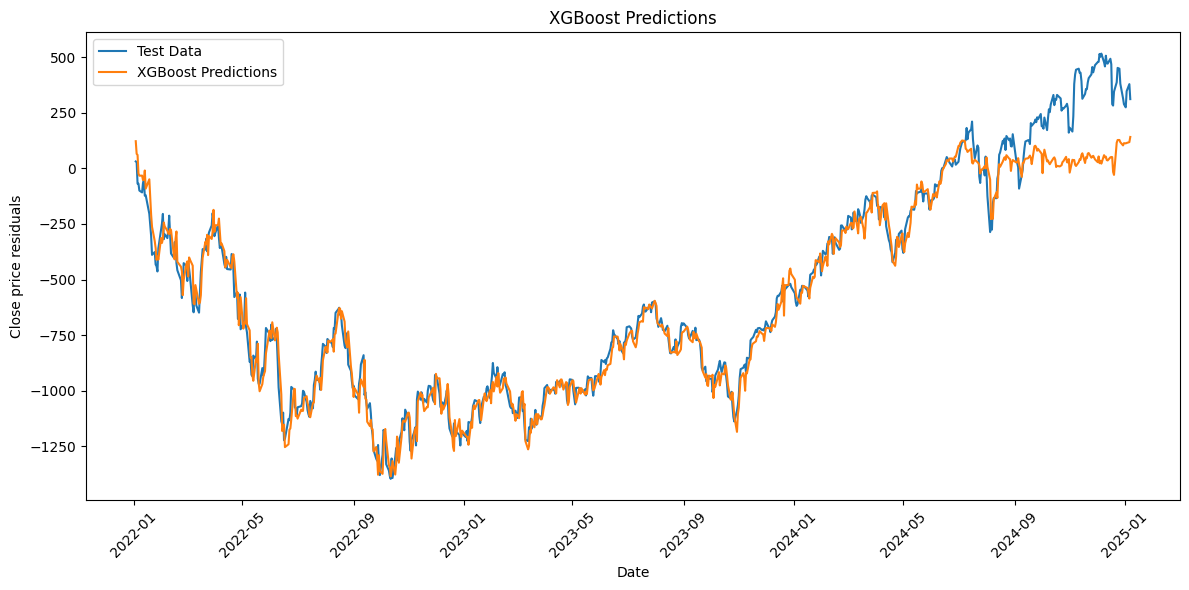

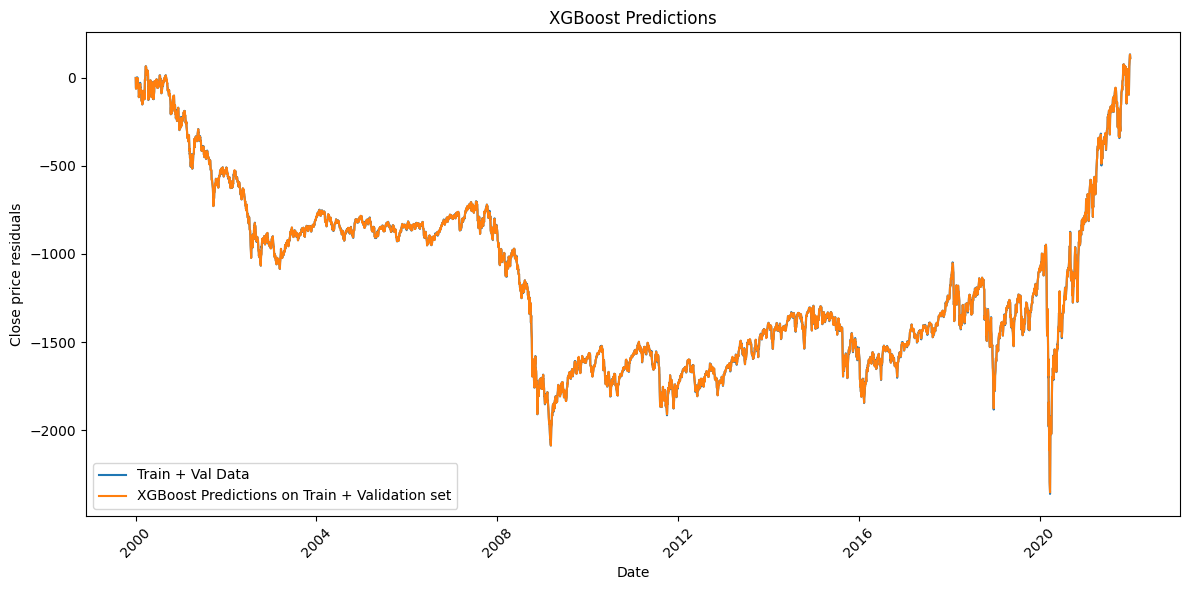

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [73]:
# train model using the best hyperparameters
best_params ={'colsample_bytree': 0.808411208122622, 'early_stopping_rounds': 17, 'gamma': 0.0005022072348654649, 'learning_rate': 0.3196968954529591, 'max_depth': 14, 'num_boost_round': 1949, 'objective': 'reg:squarederror', 'subsample': 0.7712161804793591}
model = xgb.train(best_params, dtrain_val, evals = [(dval, 'validation')], num_boost_round = best_params['num_boost_round'], early_stopping_rounds= best_params['early_stopping_rounds'], verbose_eval=False)  # Initialize xgboost model


#prediction on the test set
y_pred = model.predict(dtest)


#compute metrics
mse = mean_squared_error(dtest.get_label(), y_pred)
rmse = np.sqrt(mean_squared_error(dtest.get_label(), y_pred))
mae = mean_absolute_error(dtest.get_label(), y_pred)
r2 = r2_score(dtest.get_label(), y_pred)
print(f'RMSE: {rmse}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R2 Score: {r2}')


#visualize
plt.figure(figsize=(12, 6))
sns.lineplot(x=train_val_data.index, y=y_train_val, label="Train + Val Data")
sns.lineplot(x=test_data.index, y=y_test, label="Test Data")
sns.lineplot(x=test_data.index, y=y_pred, label="XGBoost Predictions on Test set")
plt.title('XGBoost Predictions')
plt.xlabel('Date')
plt.ylabel('Close price residuals')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()


# #close up
plt.figure(figsize=(12, 6))
# sns.lineplot(x=val_data.index, y=val_data['Residuals'].values, label="Val Data")
sns.lineplot(x= test_data.index, y = dtest.get_label(), label="Test Data")
sns.lineplot(x=test_data.index, y=y_pred, label="XGBoost Predictions")
plt.title('XGBoost Predictions')
plt.xlabel('Date')
plt.ylabel('Close price residuals')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()


#fitted values
fitted_values = model.predict(dtrain_val)
plt.figure(figsize=(12, 6))
sns.lineplot(x=train_val_data.index, y=y_train_val, label="Train + Val Data")
sns.lineplot(x=train_val_data.index, y=fitted_values, label="XGBoost Predictions on Train + Validation set")
plt.title('XGBoost Predictions')
plt.xlabel('Date')
plt.ylabel('Close price residuals')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()


#save predictions on google drive
drive.mount('/content/gdrive')
file_path = '/content/gdrive/MyDrive/università/Machine_learning/Project_code/XGBoost/XGBoost_predictions.csv'
XGBoost_predictions = pd.Series(y_pred, index=test_data.index)
XGBoost_predictions.to_csv(file_path, index=True)


##Save model

In [ ]:
#save model
drive.mount("/content/gdrive")
file_path = '/content/gdrive/MyDrive/università/Tesi/models/XGBoost_model.joblib'
dump(model, file_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


['/content/gdrive/MyDrive/università/Tesi/models/XGBoost_model.joblib']

##Compute feature importance

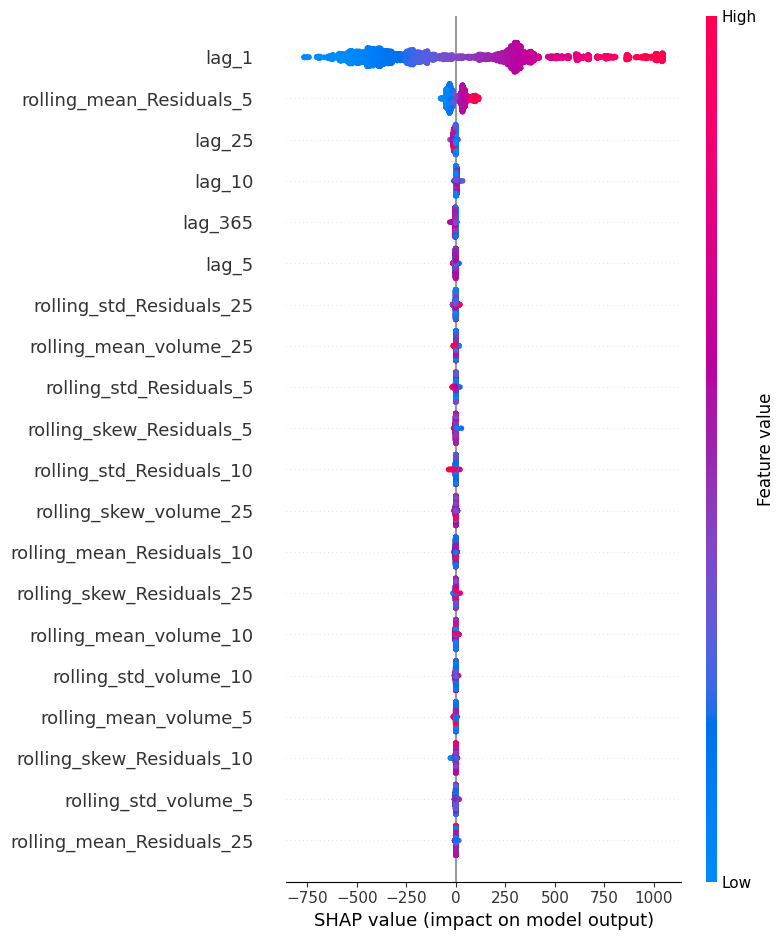

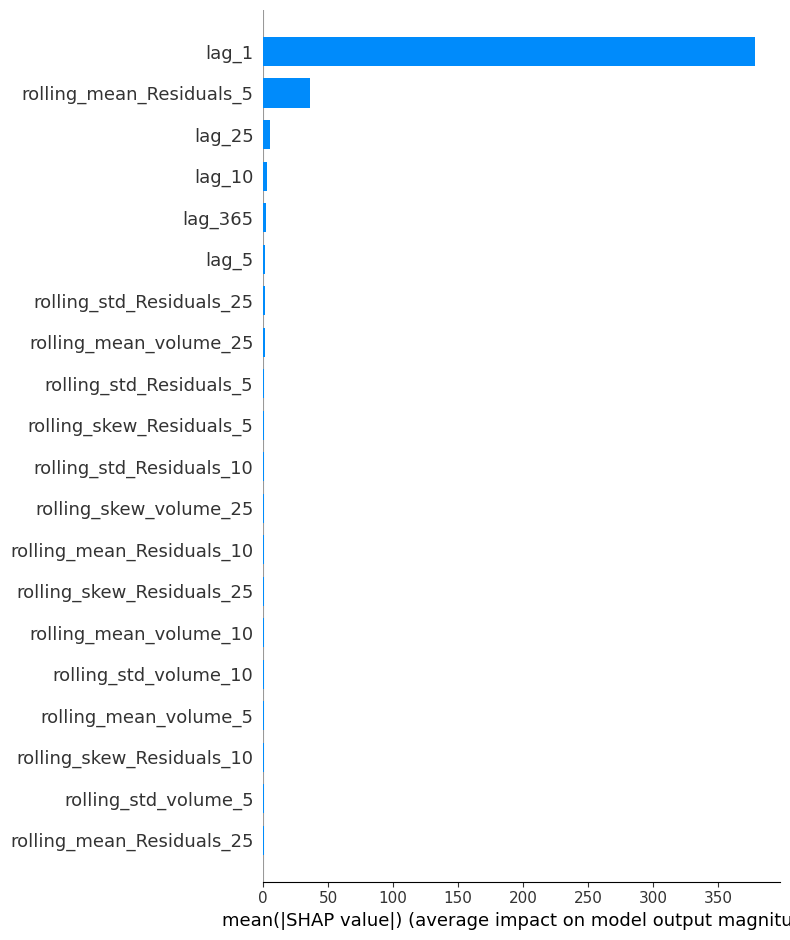

In [ ]:
# SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# Initialize SHAP visualization (only necessary for notebooks)
shap.initjs()

# Plot feature importance using SHAP
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)

# Optional: Bar plot of feature importance
shap.summary_plot(shap_values, X_train, plot_type="bar")

##Combine ARIMA and XGBoost predictions

RMSE: 111.11316925308896
Mean Squared Error: 12346.136381465594
Mean Absolute Error: 69.05630034722891
R2 Score: 0.972217591404166
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


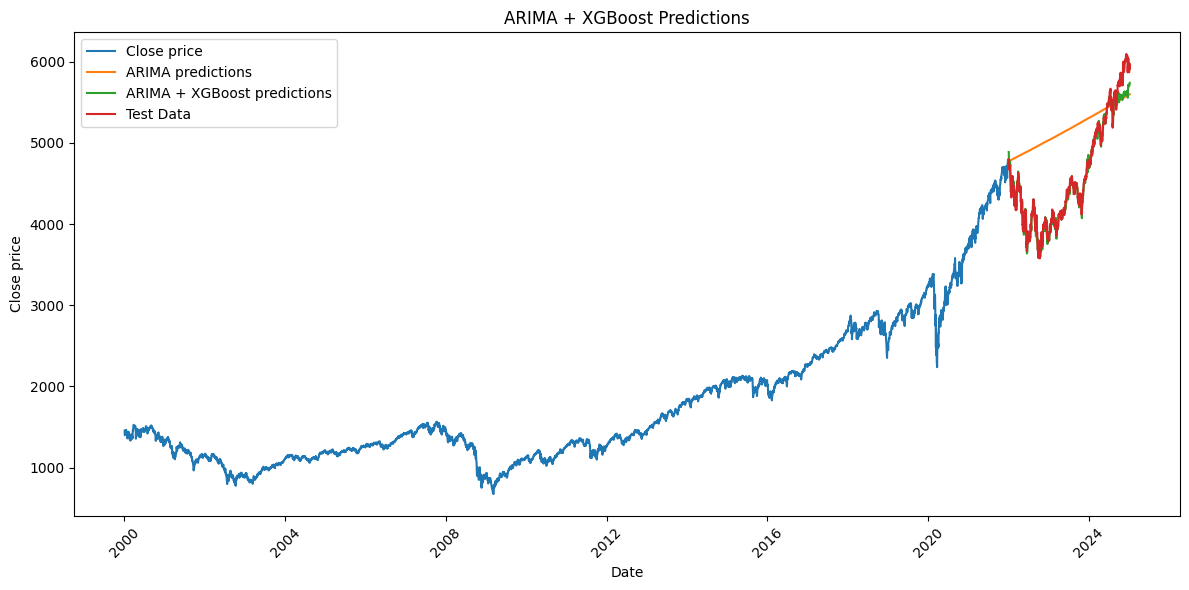

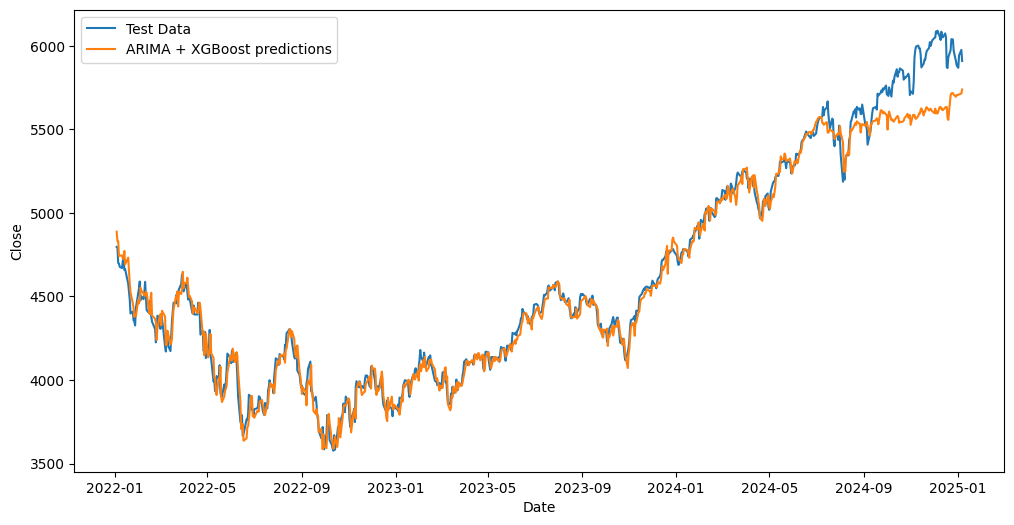

In [77]:
ARIMA_XGBoost_predictions = ARIMA_predictions + XGBoost_predictions


#compute metrics
mse = mean_squared_error(Close_price.loc[test_data.index], ARIMA_XGBoost_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Close_price.loc[test_data.index], ARIMA_XGBoost_predictions)
r2 = r2_score(Close_price.loc[test_data.index], ARIMA_XGBoost_predictions)
print(f'RMSE: {rmse}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R2 Score: {r2}')


#visualize
plt.figure(figsize=(12, 6))
sns.lineplot(x=train_val_data.index, y=Close_price.loc[train_val_data.index], label="Close price")
sns.lineplot(x=test_data.index, y=ARIMA_predictions.values.ravel(), label="ARIMA predictions")
# sns.lineplot(x=test_data.index, y=XGBoost_predictions.values.ravel(), label="XGBoost predictions")
sns.lineplot(x=test_data.index, y=ARIMA_XGBoost_predictions, label="ARIMA + XGBoost predictions")
sns.lineplot(x=test_data.index, y=Close_price.loc[test_data.index ], label="Test Data")
plt.title('ARIMA + XGBoost Predictions')
plt.xlabel('Date')
plt.ylabel('Close price')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()


#close up
plt.figure(figsize=(12, 6))
sns.lineplot(x=test_data.index, y=Close_price.loc[test_data.index ], label="Test Data")
sns.lineplot(x=test_data.index, y=ARIMA_XGBoost_predictions, label="ARIMA + XGBoost predictions")


#save ARIMA + XGBoost predictions
drive.mount('/content/gdrive')
file_path = '/content/gdrive/MyDrive/università/Machine_learning/Project_code/XGBoost/ARIMA_XGBoost_predictions.csv'
ARIMA_XGBoost_predictions = pd.Series(ARIMA_XGBoost_predictions, index=test_data.index)
ARIMA_XGBoost_predictions.to_csv(file_path, index=True)



#Residual prediction with univariate sliding windows

In [29]:
#univariate sliding window
train_data = residuals.loc[: '2018']
train_data.index = pd.to_datetime(train_data.index)

val_data = residuals.loc['2019': '2021']
val_data.index = pd.to_datetime(val_data.index)

train_val_data = residuals.loc[: '2022']
train_val_data.index = pd.to_datetime(train_val_data.index)

test_data = residuals.loc['2022':]
test_data.index = pd.to_datetime(test_data.index)


#scale the data
scaler = MinMaxScaler(feature_range=(-1, 1)) #initilise scaler
# scaler = StandardScaler()
train_data_scaled = pd.DataFrame(scaler.fit_transform(train_data.values.reshape(-1, 1)))
val_data_scaled = pd.DataFrame(scaler.transform(val_data.values.reshape(-1, 1)))
train_val_data_scaled = pd.DataFrame(scaler.fit_transform(train_val_data.values.reshape(-1, 1)))
test_data_scaled = pd.DataFrame(scaler.transform(test_data.values.reshape(-1, 1)))


def sliding_windows(data, seq_length):
    X, y = [], []

    for i in range(len(data) - seq_length ):
      _x = data.iloc[i:i+seq_length]
      _y = data.iloc[i + seq_length]
      X.append(_x)
      y.append(_y)

    return np.array(X), np.array(y)


#sliding windows
X_train, y_train  = sliding_windows(train_data_scaled, 10)
X_val, y_val= sliding_windows(val_data_scaled, 10)
X_test, y_test = sliding_windows(test_data_scaled, 10)
X_train_val , y_train_val = sliding_windows(train_val_data_scaled, 10)


# Flatten the sliding windows
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_train_val = X_train_val.reshape(X_train_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)


#convert to Dmatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtrain_val = xgb.DMatrix(X_train_val, label=y_train_val)
dtest = xgb.DMatrix(X_test, label=y_test)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:26:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "early_stopping_rounds", "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)


RMSE: 114.7704400368405
Mean Squared Error: 13172.25390625
Mean Absolute Error: 67.29410552978516
R2 Score: 0.9436136484146118


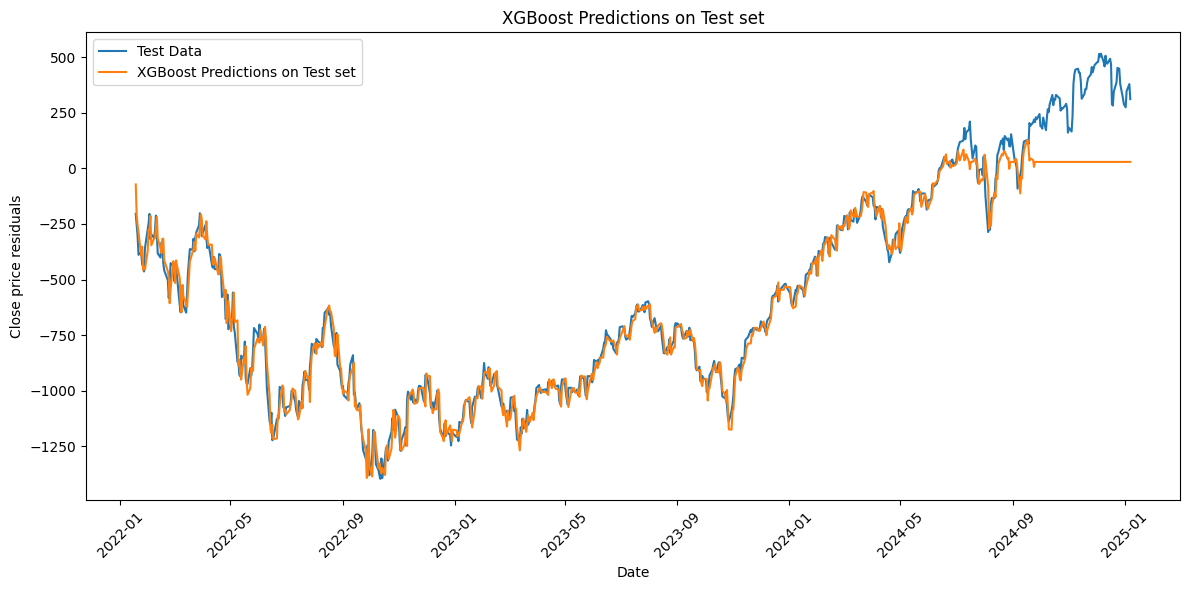

RMSE: 13.628534541004457
Mean Squared Error: 185.73695373535156
Mean Absolute Error: 10.303730010986328
R2 Score: 0.9992082118988037


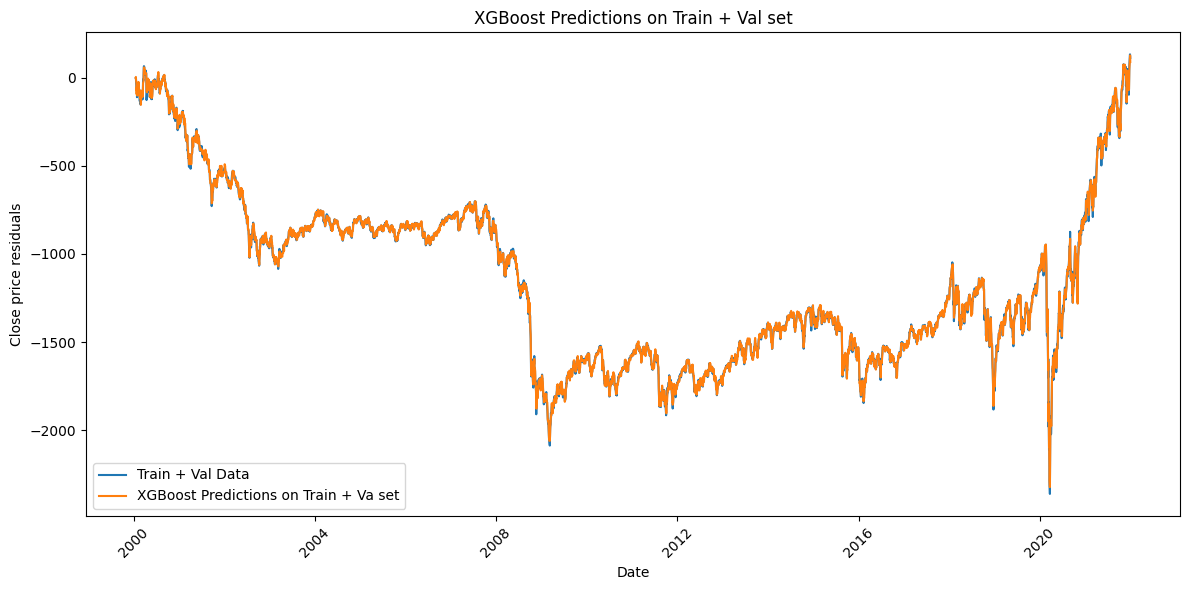

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


['/content/gdrive/MyDrive/università/Tesi/models/XGBoost_model_univariate_sliding_windows.joblib']

In [34]:
# train model using the best hyperparameters
best_params ={'colsample_bytree': 0.808411208122622, 'early_stopping_rounds': 17, 'gamma': 0.0005022072348654649, 'learning_rate': 0.3196968954529591, 'max_depth': 14, 'num_boost_round': 1949, 'objective': 'reg:squarederror', 'subsample': 0.7712161804793591}
model = xgb.train(best_params, dtrain_val, evals = [(dval, 'validation')], num_boost_round = best_params['num_boost_round'], early_stopping_rounds= best_params['early_stopping_rounds'], verbose_eval=False)  # Initialize xgboost model

#predictions
y_test_pred = model.predict(dtest)
y_train_val_pred = model.predict(dtrain_val)


#unscale predictions
y_test_pred = scaler.inverse_transform(y_test_pred.reshape(-1, 1))
y_train_val_pred = scaler.inverse_transform(y_train_val_pred.reshape(-1, 1))


#compute metrics
mse = mean_squared_error(test_data[10:], y_test_pred)
rmse = np.sqrt(mean_squared_error(test_data[10:], y_test_pred))
mae = mean_absolute_error(test_data[10:], y_test_pred)
r2 = r2_score(test_data[10:], y_test_pred)
print(f'RMSE: {rmse}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R2 Score: {r2}')


#visualize
plt.figure(figsize=(12, 6))
# sns.lineplot(x=val_data.index, y=val_data['Residuals'].values, label="Val Data")
sns.lineplot(x= test_data[10:].index, y = test_data[10:].squeeze(), label="Test Data")
sns.lineplot(x=test_data[10:].index, y=y_test_pred.squeeze(), label="XGBoost Predictions on Test set")
plt.title('XGBoost Predictions on Test set')
plt.xlabel('Date')
plt.ylabel('Close price residuals')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()


mse = mean_squared_error(train_val_data[10:], y_train_val_pred)
rmse = np.sqrt(mean_squared_error(train_val_data[10:], y_train_val_pred))
mae = mean_absolute_error(train_val_data[10:], y_train_val_pred)
r2 = r2_score(train_val_data[10:], y_train_val_pred)
print(f'RMSE: {rmse}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R2 Score: {r2}')


#visualize
plt.figure(figsize=(12, 6))
sns.lineplot(x= train_val_data[10:].index, y = train_val_data[10:].squeeze(), label="Train + Val Data")
sns.lineplot(x=train_val_data[10:].index, y=y_train_val_pred.squeeze(), label="XGBoost Predictions on Train + Va set")
plt.title('XGBoost Predictions on Train + Val set')
plt.xlabel('Date')
plt.ylabel('Close price residuals')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()


#save model on google drive
drive.mount("/content/gdrive")
file_path = '/content/gdrive/MyDrive/università/Tesi/models/XGBoost_model_univariate_sliding_windows.joblib'
dump(model, file_path)

##Combine ARIMA + XGBoost

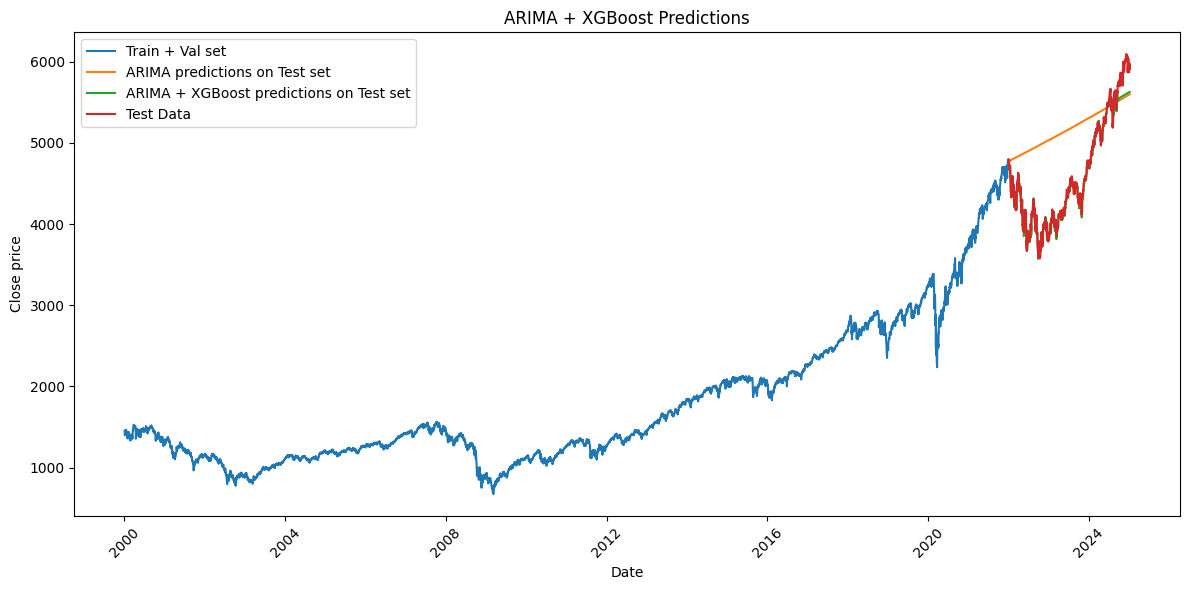

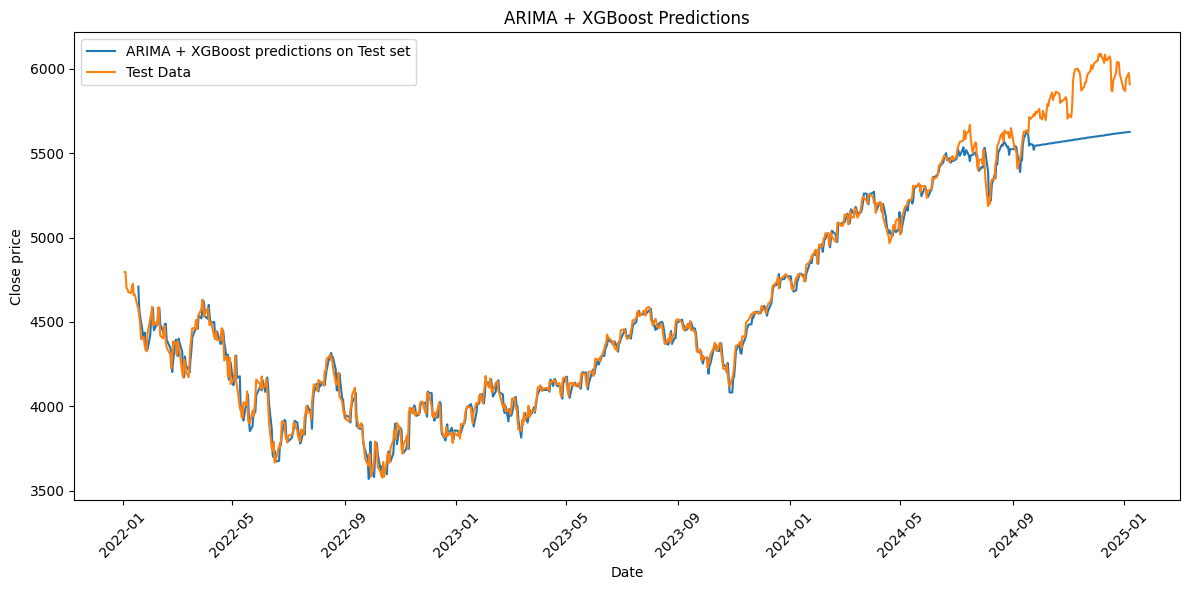

RMSE: 114.7704473682511
Mean Squared Error: 13172.255589108496
Mean Absolute Error: 67.29410731287162
R2 Score: 0.9707397997940875


In [51]:
ARIMA_XGBoost_predictions = ARIMA_predictions[10:] + y_test_pred.squeeze()

#visualize
plt.figure(figsize=(12, 6))
sns.lineplot(x=train_val_data.index, y=Close_price.loc[train_val_data.index], label="Train + Val set")
sns.lineplot(x=test_data.index, y=ARIMA_predictions.values.ravel(), label="ARIMA predictions on Test set")
# sns.lineplot(x=test_data.index, y=XGBoost_predictions.values.ravel(), label="XGBoost predictions")
sns.lineplot(x=test_data[10:].index, y=ARIMA_XGBoost_predictions, label="ARIMA + XGBoost predictions on Test set")
sns.lineplot(x=test_data.index, y=Close_price.loc[test_data.index ], label="Test Data")
plt.title('ARIMA + XGBoost Predictions')
plt.xlabel('Date')
plt.ylabel('Close price')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()


#close up
plt.figure(figsize=(12, 6))
sns.lineplot(x=test_data[10:].index, y=ARIMA_XGBoost_predictions, label="ARIMA + XGBoost predictions on Test set")
sns.lineplot(x=test_data.index, y=Close_price.loc[test_data.index ], label="Test Data")
plt.title('ARIMA + XGBoost Predictions')
plt.xlabel('Date')
plt.ylabel('Close price')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()


#compute metrics
mse = mean_squared_error(Close_price.loc[test_data[10:].index ], ARIMA_XGBoost_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Close_price.loc[test_data[10:].index ], ARIMA_XGBoost_predictions)
r2 = r2_score(Close_price.loc[test_data[10:].index ], ARIMA_XGBoost_predictions)
print(f'RMSE: {rmse}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R2 Score: {r2}')

#Naive model

MSE:  570561.9042888356
RMSE:  755.3554820671096
MAE:  593.5665020938114
R2:  -1.4396191182451599


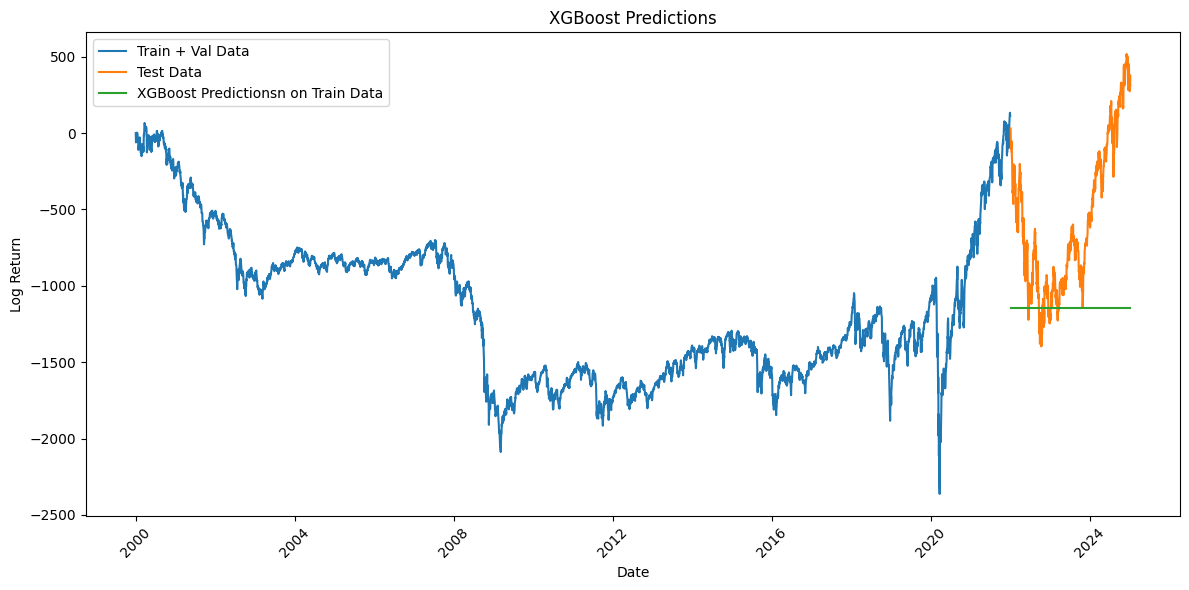

In [33]:
#naive model that predict the means
class naive_estimator:
    def __init__(self):
        self.mean_value = None  # Initialize mean

    def fit(self, train_data):
      self.mean_value = np.mean(train_data.iloc[:,0])

    def predict(self, test_data):
      return np.full(len(test_data), self.mean_value)  # Creates array of mean values


train_data = residuals.loc[: '2018']
train_data.index = pd.to_datetime(train_data.index)

val_data = residuals.loc['2019': '2021']
val_data.index = pd.to_datetime(val_data.index)

train_val_data = residuals.loc[: '2022']
train_val_data.index = pd.to_datetime(train_val_data.index)

test_data = residuals.loc['2022':]
test_data.index = pd.to_datetime(test_data.index)


#train + fit naive model
mean_esitmator = naive_estimator()
mean_esitmator.fit(train_val_data)
test_predictions = mean_esitmator.predict(test_data)


mse = mean_squared_error(test_data, test_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data, test_predictions)
r2 = r2_score(test_data, test_predictions)
print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('R2: ', r2)


#visualize
plt.figure(figsize=(12, 6))
sns.lineplot(x=train_val_data.index, y=train_val_data.squeeze(), label="Train + Val Data")
sns.lineplot(x=test_data.index, y=test_data.squeeze(), label="Test Data")
sns.lineplot(x=test_data.index, y=test_predictions, label="XGBoost Predictionsn on Train Data")
plt.title('XGBoost Predictions')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()

#XGBOOST

## multivariate sliding windows and standardise each slice

In [ ]:
#slice first and then stardardize as explained in this paper (https://www.researchgate.net/publication/334316495_Financial_Time_Series_Data_Processing_for_Machine_Learning)
def sliding_windows(data, seq_length, num_cols, cat_cols):
    X, y = [], []
    data_num = data[num_cols]
    data_cat = data[cat_cols]
    # scaler = MinMaxScaler() #initialize scaler

    for i in range(len(data) - seq_length ):
      # _x_num_scaled = scaler.fit_transform(data_num.iloc[i:i+seq_length])  # slice and scale numerical columns
      # _x_cat = data_cat.iloc[i:i+seq_length].values #slice cat columns
      # _x = np.concatenate([_x_num_scaled, _x_cat], axis=1) # Concatenate scaled numerical data with categorical data

      _x = data.iloc[i:i+seq_length, 1:]
      _y = data.iloc[i + seq_length, 0]
      X.append(_x)
      y.append(_y)

    return np.array(X), np.array(y)



#sliding windows
X_train, y_train  = sliding_windows(train_data, 5, num_cols, cat_cols)
X_val, y_val= sliding_windows(val_data, 5, num_cols, cat_cols)
X_test, y_test = sliding_windows(test_data, 5, num_cols, cat_cols)
X_train_val , y_train_val = sliding_windows(train_val_data, 5, num_cols, cat_cols)


# Reshape X to be 2D (samples, seq_length * num_features)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
X_train_val_flat = X_train_val.reshape(X_train_val.shape[0], -1)


# Convert to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train_flat, label=y_train)
dval = xgb.DMatrix(X_val_flat, label=y_val)
dtest = xgb.DMatrix(X_test_flat, label=y_test)
dtrain_val = xgb.DMatrix(X_train_val_flat, label=y_train_val)